# Here the methods: DPCM, MS Stereo, MS Quadro, Channel Mean removal, Rice Coding, and Huffman coding will be illustrated

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

s = np.load('../test_data_sintef.npy')

# calculate min num bits we need to allocate to the original
bO = len(bin(np.max(np.abs(s)).astype(int))[2:])

# Define signal
x = s[:12000,:].astype(int)

# Rice coding parameter
K = 9

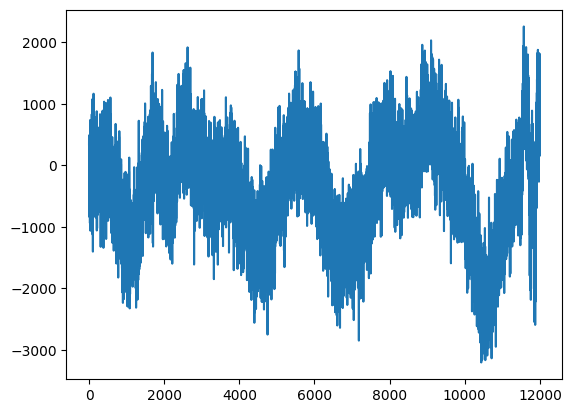

In [2]:
plt.plot(x[:,0])

# DPCM

In [3]:
def dpcm(x):
    previousSample = 0 # initial predicted value

    residual = np.zeros_like(x) # residual signal

    for i in range(len(x)): 
        residual[i] = x[i] - previousSample # residual is true - predict

        previousSample = x[i] # reconstruct by adding residual to past sample
    
    return  residual

# inverse DPCM
def dpcm_i(x):
    previousSample = 0 # initial predicted value

    predict = np.zeros_like(x) # reconstructed signal

    for i in range(len(x)): 

        previousSample = previousSample + x[i] # reconstruct by adding residual to past sample
        
        predict[i] = previousSample # predicted value is set to be the past sample
    return predict


Perform DPCM

In [4]:
#perform DPCM
predictedSignal = []
residualSignal = []
for i in range(x.shape[1]): # loop through all channels
    res = dpcm(x[:,i])
    pred = dpcm_i(res)
    predictedSignal.append(pred)
    residualSignal.append(res)

### Test the results

quantized value that is transmitted:
0b10110
value obtained from adding this to last signal:
-0b101110100
original signal:
-0b101110100


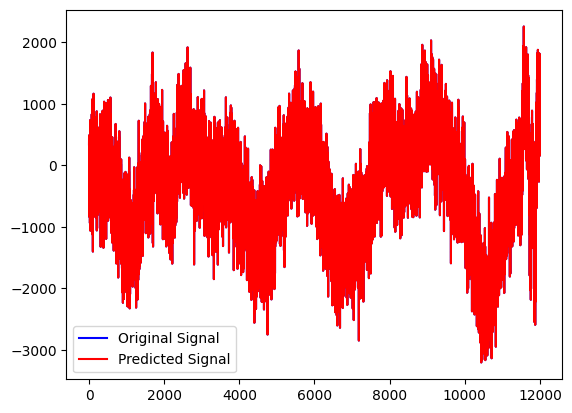

In [5]:
#Test one channel:
# Plot the original and predicted signals
k = 0
plt.plot(x[:,k], 'b')
plt.plot(predictedSignal[k], 'r') 
plt.legend(['Original Signal', 'Predicted Signal'])

i = 6 #we check signal num 6 just for fun
print('quantized value that is transmitted:')
print(bin(int(residualSignal[k][i])))

predict = residualSignal[k][i] + predictedSignal[k][i-1]
print('value obtained from adding this to last signal:')
print(bin(int(predict)))

print('original signal:')
print(bin(int(x[i,k])))

In [11]:
# calculate min num bits we need to allocate
bR = len(bin(np.max(np.abs(np.array(residualSignal))).astype(int))[2:])
error = np.sum(np.abs(x - np.array(predictedSignal).T))
print(f'Bits used on compressed signal: {bR}')
print(f'Error: {error:.2f}')

Bits used on compressed signal: 13
Error: 0.00


Plot the residual signal and its distribution to make sure that it looks like a Laplacian dist, so that it is resonable to use Rice coding

(array([2.43072436e-06, 1.82304327e-06, 4.86144871e-06, 1.45843461e-05,
        2.55226057e-05, 4.61837628e-05, 7.10986874e-05, 1.23359261e-04,
        1.86558094e-04, 2.61910549e-04, 3.35439961e-04, 3.89523578e-04,
        5.52989791e-04, 5.82766164e-04, 6.46572679e-04, 7.12809917e-04,
        6.39280506e-04, 6.72095284e-04, 5.20175012e-04, 4.61837628e-04,
        3.51847351e-04, 2.29703452e-04, 1.67719981e-04, 1.22751580e-04,
        6.74526009e-05, 5.22605737e-05, 2.24842003e-05, 1.33689840e-05,
        9.11521633e-06, 3.64608653e-06]),
 array([-2128.        , -1990.86666667, -1853.73333333, -1716.6       ,
        -1579.46666667, -1442.33333333, -1305.2       , -1168.06666667,
        -1030.93333333,  -893.8       ,  -756.66666667,  -619.53333333,
         -482.4       ,  -345.26666667,  -208.13333333,   -71.        ,
           66.13333333,   203.26666667,   340.4       ,   477.53333333,
          614.66666667,   751.8       ,   888.93333333,  1026.06666667,
         1163.2       

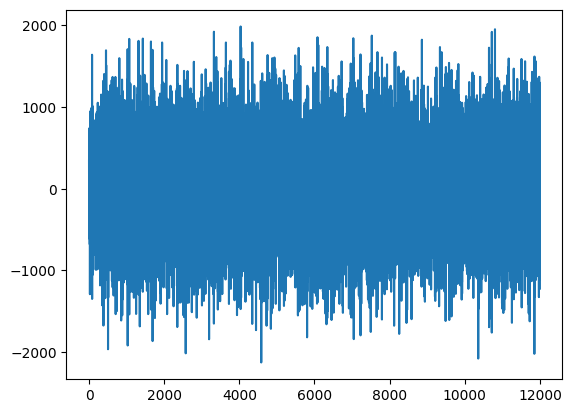

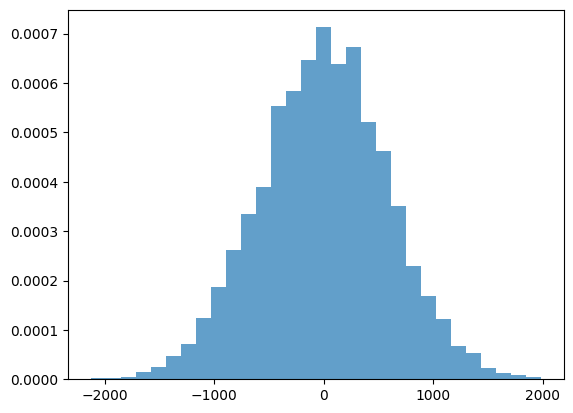

In [12]:
# check for channel 1
plt.figure(1)
plt.plot(residualSignal[0])
plt.figure(2)
plt.hist(residualSignal[0], bins=30, density=True, alpha=0.7)

# MS stereo coding (Sum/Difference coding):

In [13]:
def stereo(temp): 
    channelPairs = [[0,1],[2,3],[4,5],[6,7],[8,9], [10,11], [12,13], [14,15]] # compare the channels closest to each other

    S = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    D = np.zeros([temp.shape[0],int(temp.shape[1]/2)])

    k = 0
    for i in channelPairs:
        # encode
        S[:,k] = 0.5*(temp[:,i[0]] + temp[:,i[1]]) # take avg. of all samples of the two channels
        D[:,k] = 0.5*(temp[:,i[0]] - temp[:,i[1]]) # take diff. of all samples of the two channels
        
        k += 1
    return D, S

def stereo_i(temp):
    channelPairs = [[0,1],[2,3],[4,5],[6,7],[8,9], [10,11], [12,13], [14,15]] # compare the channels closest to each other
    
    S = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    D = np.zeros([temp.shape[0],int(temp.shape[1]/2)])
    predict = np.zeros_like(temp)

    D, S = np.split(temp, 2, axis=1)

    k = 0
    for i in channelPairs:
        
        # decode
        predict[:,i[0]] = S[:,k] + D[:,k] # reconstruct original channels
        predict[:,i[1]] = S[:,k] - D[:,k]
        
        k += 1
    return predict

In [14]:
# conpute the SumDiff with the given pairs
D, S = stereo(x)
DS = np.concatenate((D,S),1)

predict = stereo_i(DS)

### Testing the results:

In [15]:
# calculate min num bits we need to allocate
bDS = len(bin(np.max(np.abs(DS)).astype(int))[2:])
error = np.sum(np.abs(x - predict))
print(f'Bits used on compressed signal: {bDS}')
print(f'Error: {error:.2f}')

Bits used on compressed signal: 13
Error: 0.00


Check that the result has the right distribution to be used in Rice coding

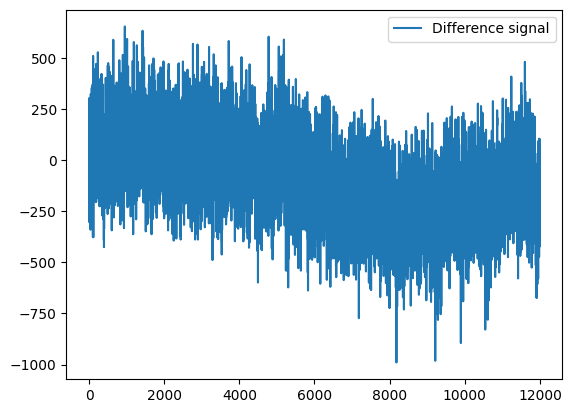

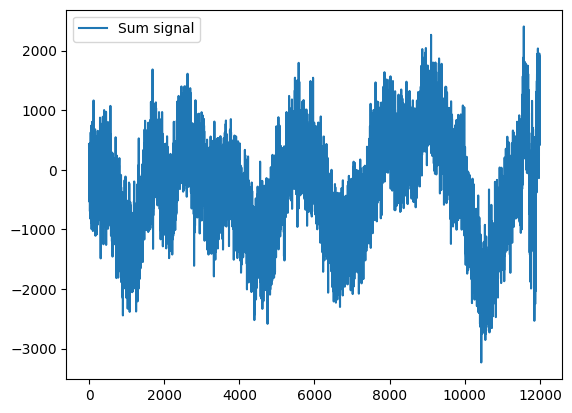

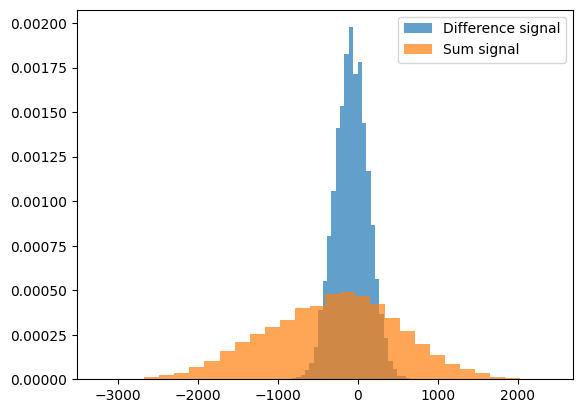

In [16]:
plt.figure(1)
plt.plot(D[:,0])
plt.legend(['Difference signal'])

plt.figure(2)
plt.plot(S[:,0])
plt.legend(['Sum signal'])

plt.figure(3)
plt.hist(D[:,0], bins=30, density=True, alpha=0.7)
plt.hist(S[:,0], bins=30, density=True, alpha=0.7)
plt.legend(['Difference signal', 'Sum signal'])

# MS Quadro

In [17]:
def quadro(temp): 
    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP
    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG

    # initialize
    Q1 = np.zeros([temp.shape[0],3])
    Q2 = np.zeros([temp.shape[0],3])
    Q3 = np.zeros([temp.shape[0],3])
    Q4 = np.zeros([temp.shape[0],3])
    
    S = np.zeros([temp.shape[0],2])
    D = np.zeros([temp.shape[0],2])

    k = 0 # counting channels in one quartet
    for i in channelQuartets:
        # encode
        Q1[:,k] = 0.25*(temp[:,i[0]] + temp[:,i[1]] + temp[:,i[2]] + temp[:,i[3]])
        Q2[:,k] = 0.25*(temp[:,i[0]] - temp[:,i[1]] - temp[:,i[2]] + temp[:,i[3]])
        Q3[:,k] = 0.25*(temp[:,i[0]] - temp[:,i[1]] + temp[:,i[2]] - temp[:,i[3]])
        Q4[:,k] = 0.25*(temp[:,i[0]] + temp[:,i[1]] - temp[:,i[2]] - temp[:,i[3]])

        k += 1
    
    k = 0 # counting channles in one duo
    for i in channelPairs:
        # encode
        S[:,k] = 0.5*(temp[:,i[0]] + temp[:,i[1]])
        D[:,k] = 0.5*(temp[:,i[0]] - temp[:,i[1]])

        k += 1
    

    Q = np.concatenate((Q1,Q2,Q3,Q4,D,S),1)

    return Q

def quadro_i(temp):
    channelQuartets = [[0,1,2,3],[4,5,6,7],[8,9,10,11]] # compare the channels closes to each other: LFP/AP
    channelPairs = [[12,13], [14,15]] # compare the channels closes to each other: EcoG and EMG

    predict = np.zeros_like(temp)

    split1, split2, split3, split4 = np.split(temp, 4, axis=1)
    split5 = np.concatenate((split1, split2, split3), axis=1)
    Q1,Q2,Q3,Q4 = np.split(split5, 4, axis=1)
    D,S = np.split(split4, 2, axis=1)

    k = 0 # counting channels in one quartet
    for i in channelQuartets:

        # decode
        predict[:,i[0]] = (Q1[:,k] + Q2[:,k] + Q3[:,k] + Q4[:,k])
        predict[:,i[1]] = (Q1[:,k] - Q2[:,k] - Q3[:,k] + Q4[:,k])
        predict[:,i[2]] = (Q1[:,k] - Q2[:,k] + Q3[:,k] - Q4[:,k])
        predict[:,i[3]] = (Q1[:,k] + Q2[:,k] - Q3[:,k] - Q4[:,k])

        k += 1
    
    k = 0 # counting channles in one duo
    for i in channelPairs:
        
        # decode
        predict[:,i[0]] = (S[:,k] + D[:,k])
        predict[:,i[1]] = (S[:,k] - D[:,k])
        
        k += 1

    return predict

In [18]:
# perform compression
Q = quadro(x)

predict = quadro_i(Q)

### Testing the results:

In [19]:
# calculate min num bits we need to allocate
bQ = len(bin(np.max(np.abs(Q)).astype(int))[2:])
error = np.sum(np.abs(x - predict))
print(f'Bits used on compressed signal: {bQ}')
print(f'Error: {error:.2f}')

Bits used on compressed signal: 13
Error: 0.00


Check that the result has the right distribution to be used in Rice coding

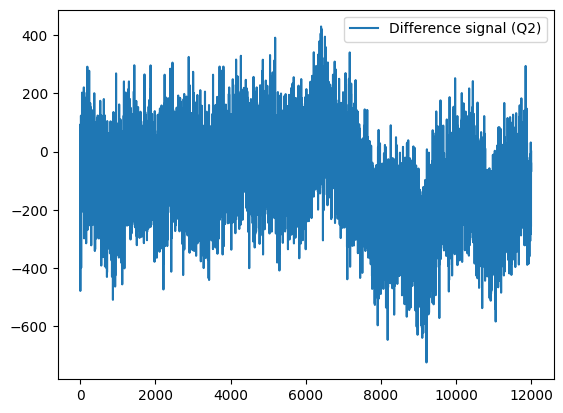

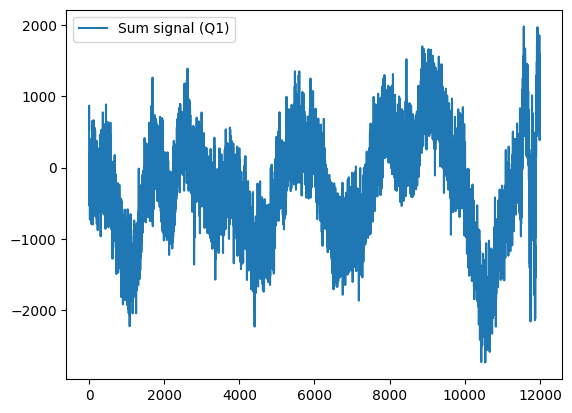

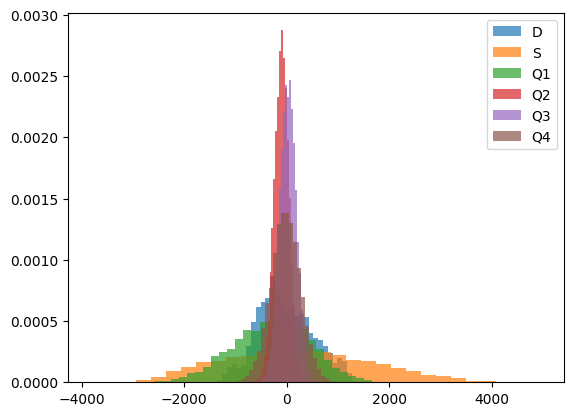

In [20]:
split1, split2, split3, split4 = np.split(Q, 4, axis=1)
split5 = np.concatenate((split1, split2, split3), axis=1)
Q1,Q2,Q3,Q4 = np.split(split5, 4, axis=1)
D,S = np.split(split4, 2, axis=1)

plt.figure(1)
plt.plot(Q2[:,0])
plt.legend(['Difference signal (Q2)'])

plt.figure(2)
plt.plot(Q1[:,0])
plt.legend(['Sum signal (Q1)'])

plt.figure(3)
plt.hist(D[:,0], bins=30, density=True, alpha=0.7)
plt.hist(S[:,0], bins=30, density=True, alpha=0.7)
plt.hist(Q1[:,0], bins=30, density=True, alpha=0.7)
plt.hist(Q2[:,0], bins=30, density=True, alpha=0.7)
plt.hist(Q3[:,0], bins=30, density=True, alpha=0.7)
plt.hist(Q4[:,0], bins=30, density=True, alpha=0.7)
plt.legend(['D', 'S', 'Q1', 'Q2', 'Q3', 'Q4'])

# Channel mean removal

In [21]:
def chmean(temp): 
    output = np.zeros((temp.shape[0], temp.shape[1] + 1))
    for i in range(temp.shape[1]):
        output[:,i] = temp[:,i] - np.mean(temp, axis=1) 
    output[:,-1] = np.mean(temp, axis=1) 

    return output

def chmean_i(temp):
    output = np.zeros((temp.shape[0], temp.shape[1]-1))
    for i in range(temp.shape[1]-1):
        output[:,i] = temp[:,i] + temp[:,-1]

    return output

In [22]:
CH = chmean(x)

predict = chmean_i(CH)

### Testing the results:

In [23]:
# calculate min num bits we need to allocate
bCH = len(bin(np.max(np.abs(CH)).astype(int))[2:])
error = np.sum(np.abs(x - predict))
print(f'Bits used on compressed signal: {bCH}')
print(f'Error: {error:.2f}')

Bits used on compressed signal: 13
Error: 0.00


Check that the result has the right distribution to be used in Rice coding

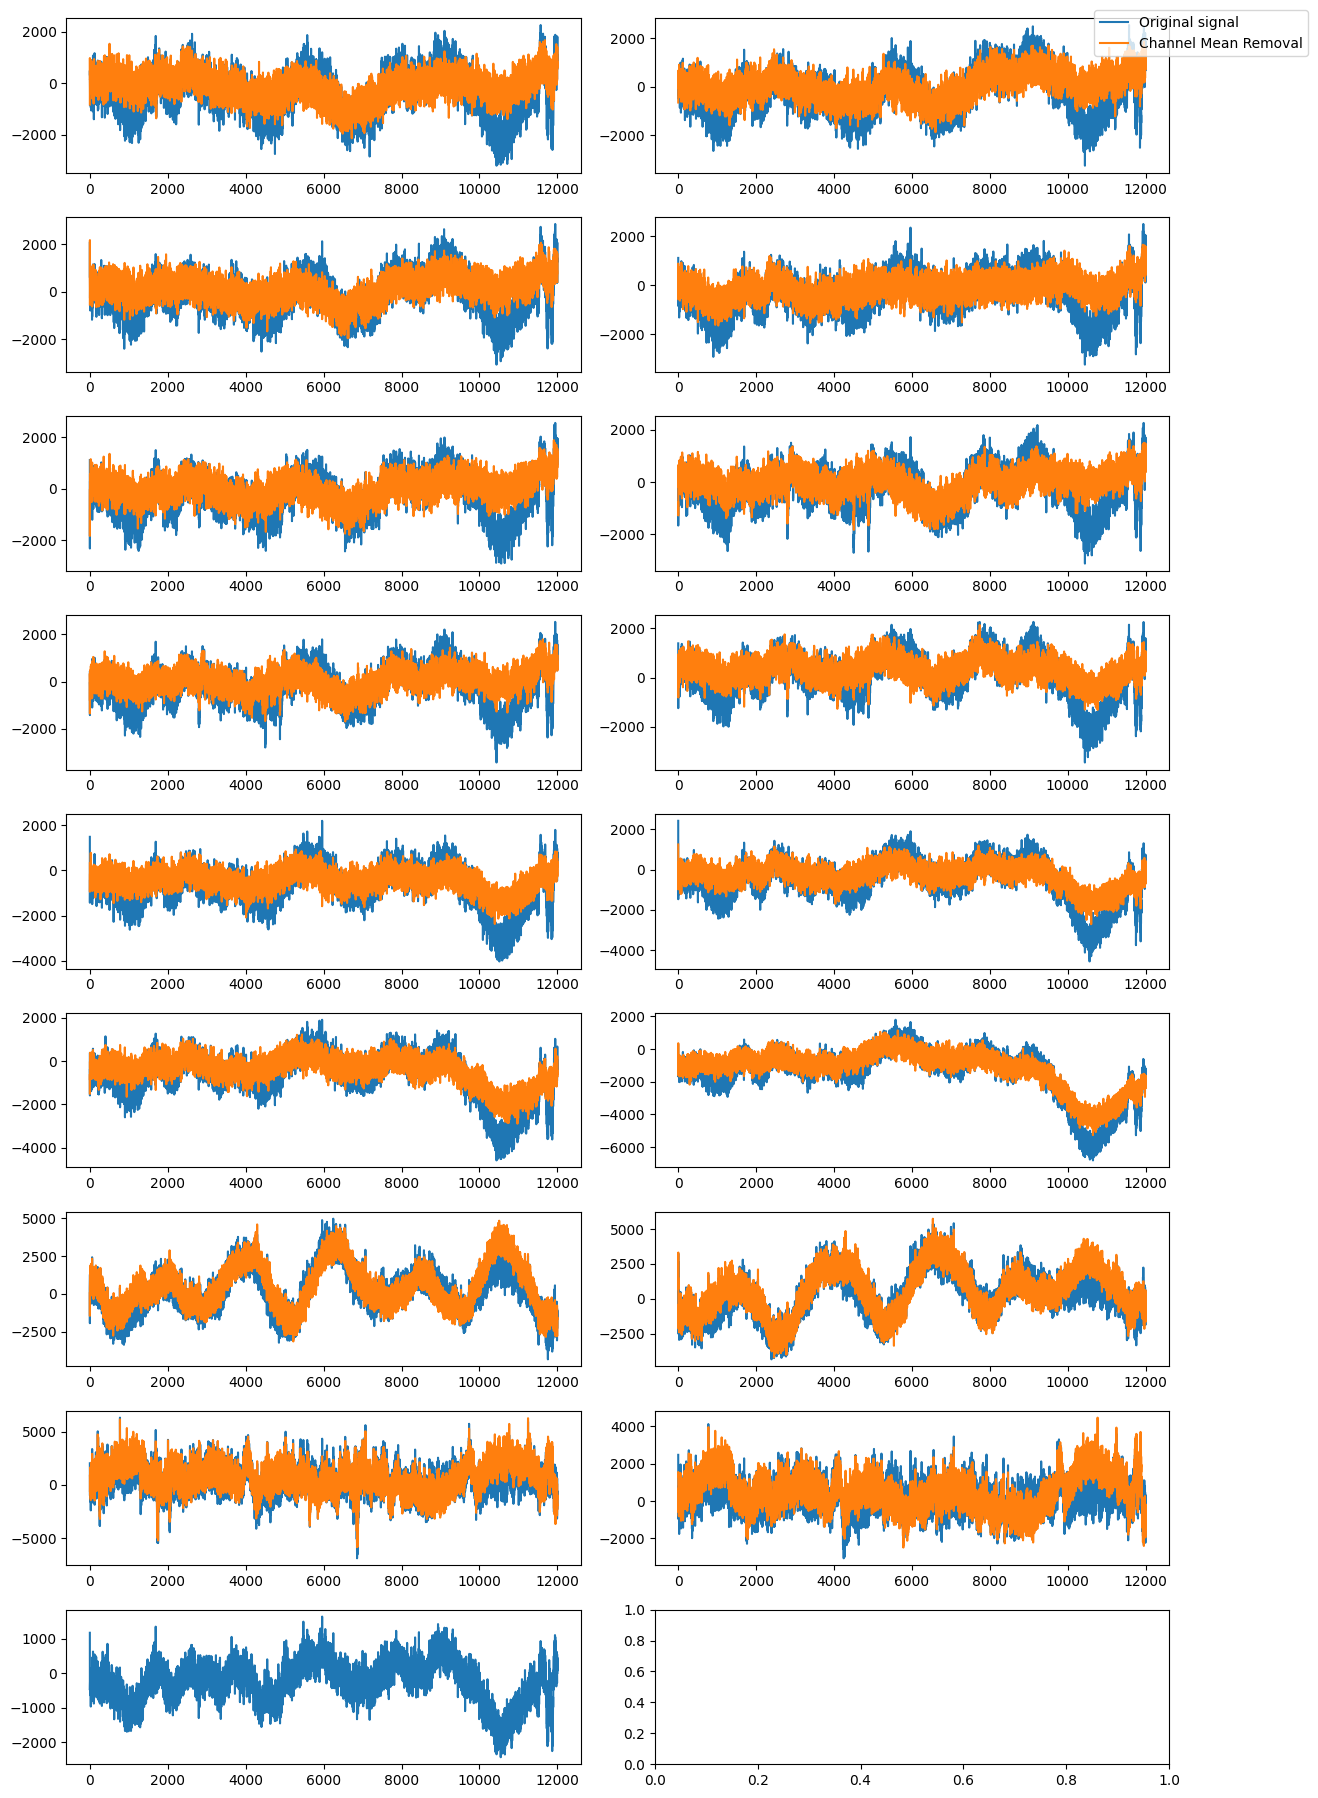

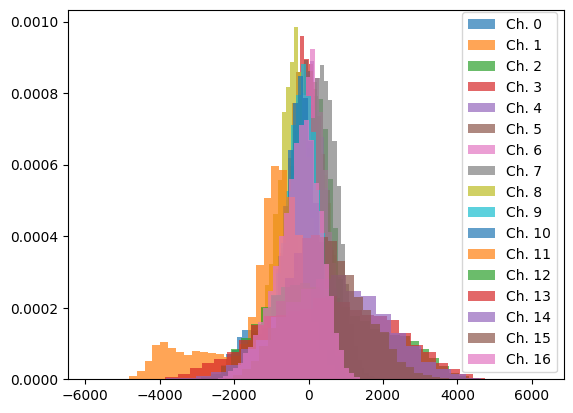

In [24]:
# Plot the channels with mean removed, ch. 17 is the mean channel
fig, axs = plt.subplots(9, 2, figsize=(12, 18))
for i in range(CH.shape[1]):
    if i != 16:
        axs.flatten()[i].plot(x[:,i])
    axs.flatten()[i].plot(CH[:,i])
fig.legend(['Original signal', 'Channel Mean Removal'], loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout() 
plt.show()

leg = []
plt.figure()
for i in range(CH.shape[1]):
    plt.hist(CH[:,i], bins=30, density=True, alpha=0.7)
    leg.append('Ch. ' + str(i))
plt.legend(leg)

# Rice Coding

### Define the functions and compute Rice

In [25]:
def rice_encode_array_sign(values, K, alpha = 0.5):
    encoded_values = []
    window = 40

    # look at window values at a time, update the divisor, and use this to perform rice coding on the window
    for i in range(int(len(values)/window)):
        if (i>0):
            if (np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window])) == 0):
                K = 0 # since log2(0) is not possible
            else:
                K = np.round( alpha*np.log2(np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window]))) + (1-alpha)*K )
                if(K<0): 
                    K = 0
        K = int(K)
              
        divisor = int(2**K) # can be impelented by right shifting

        encoded_values.append(bin(K)[2:].zfill(4)) # send the K-value that is used

        for value in values[i*window:i*window + window]: 
            sign_bit = "1" if value < 0 else "0" 
            abs_value = abs(value)

            quotient = abs_value // divisor
            remainder = abs_value % divisor

            unary_code = "1" * quotient + "0"
            binary_code = bin(remainder)[2:].zfill(divisor.bit_length() - 1)

            encoded_values.append(sign_bit + unary_code + binary_code) # since the length of the remainder is know the sign bit position is also known (fist after)

    return encoded_values

def rice_decode_array_sign(encoded_values):
    decoded_values = []
    window = 40
    counter = 0

    for encoded_value in encoded_values:
        if counter == 0: 
            K = int(encoded_value, 2)
            divisor = int(2**K)
            counter = window
        else:
            counter -= 1

            sign_bit = encoded_value[0]
            quotient = encoded_value[1:].index("0") #+ 1
            remainder = int(encoded_value[quotient + 1:], 2)

            value = quotient * divisor + remainder
            if sign_bit == "1":
                value = -value

            decoded_values.append(value)

    return decoded_values

In [26]:
# here the sign bit is implemented as described here: https://en.wikipedia.org/wiki/Golomb_coding
# from testing the two ways of implementing the sign bit give the same results
def rice_encode(values, K, alpha = 0.5):
    encoded_values = []
    window = 40

    # look at window values at a time, update the divisor, and use this to perform rice coding on the window
    for i in range(int(len(values)/window)):
        if (i>0):
            if (np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window])) == 0):
                K = 0 # since log2(0) is not possible
            else:
                K = np.round( alpha*np.log2(np.log(2)*np.mean(np.abs(values[(i-1)*window:(i-1)*window + window])*2)) + (1-alpha)*K )
                if(K<0): 
                    K = 0
        K = int(K)
              
        divisor = int(2**K) # can be impelented by right shifting

        encoded_values.append(bin(K)[2:].zfill(4)) # send the K-value that is used

        for value in values[i*window:i*window + window]: 
            
            # make sure that positive and negative numbers get unique values
            if value >= 0:
                abs_value = abs(value)*2
            else: 
                abs_value = abs(value)*2 - 1

            quotient = abs_value // divisor
            remainder = abs_value % divisor

            unary_code = "1" * quotient + "0"
            binary_code = bin(remainder)[2:].zfill(divisor.bit_length() - 1)

            encoded_values.append(unary_code + binary_code)

    return encoded_values

def rice_decode(encoded_values):
    decoded_values = []
    window = 40
    counter = 0

    for encoded_value in encoded_values:
        if counter == 0: 
            K = int(encoded_value, 2)
            divisor = int(2**K)
            counter = window
        else:
            counter -= 1

            quotient = encoded_value[:].index("0") 
            remainder = int(encoded_value[quotient:], 2)

            value = quotient * divisor + remainder

            # determine if the value was positive or negative
            if value % 2 == 0:
                value = value // 2
            else: 
                value = - (value+1) // 2

            decoded_values.append(value)

    return decoded_values

In [27]:
# calculate best k (to get the best divisor m): 
np.log2(np.log(2)*np.mean(np.abs(x)))

9.226195137102788

In [28]:

encoded = []
encoded_alt_sign = []
decoded = np.zeros_like(x)

for i in range(x.shape[1]):
    print('Channel: ' + str(i)) # print channel to keep track of progress
    encoded_alt_sign.append(           rice_encode(x[:,i], K))
    encoded.append(         rice_encode_array_sign(x[:,i], K))
    decoded[:,i] = np.array(rice_decode_array_sign(encoded[i]))


Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15


# Results Rice:

In [29]:
error = 0
lenOriginal = 0
lenRice = 0
lenRice_alt_sign = 0

 
for j in range(x.shape[1]):
    error += np.sum(np.abs(decoded[:,j] - x[:,j]))
    for i in range(x.shape[0]):
        lenOriginal += bO # 
        lenRice += len(encoded[j][i])
        lenRice_alt_sign += len(encoded_alt_sign[j][i])


    

print(f'Total compression error: {error:.2f}')
print(f'Length of original signal: {lenOriginal}')
print(f'Length of encoded signal: {lenRice}')
print(f'Length of encoded signal using alternative sign method: {lenRice_alt_sign}')


RCR2 = (1 - lenRice_alt_sign/lenOriginal) * 100
RCR = (1 - lenRice/lenOriginal) * 100
CR = lenOriginal/lenRice 
print(f'Compression ratio (RCR) of Rice: {RCR:.2f}%')
print(f'Compression ratio (RCR) of Rice (with alternative sign method): {RCR2:.2f}%')
print(f'CR: {CR:.2f}')


print('\n')
print('--------------------Looking at a single sample--------------------')

k = 0
i = 12 #we check signal num 6 just for fun

print('Original sample:')
x_bin = bin(int(x[i,k]))
if x_bin[0] == '-': 
    x_bin = x_bin[3:].zfill(bO)
    x_bin = '1' + x_bin
else: 
    x_bin = x_bin[2:].zfill(bO)
    x_bin = '0' + x_bin
print(x_bin)


print('Quantized value that is transmitted:')
print(encoded[k][i])


print('Decoded value:')
decoded_bin = bin(int(decoded[i,k]))
if decoded_bin[0] == '-': 
    decoded_bin = decoded_bin[3:].zfill(bO)
    decoded_bin = '1' + decoded_bin
else: 
    decoded_bin = decoded_bin[2:].zfill(bO)
    decoded_bin = '0' + decoded_bin
print(decoded_bin)

Total compression error: 0.00
Length of original signal: 3072000
Length of encoded signal: 2263829
Length of encoded signal using alternative sign method: 2263538
Compression ratio (RCR) of Rice: 26.31%
Compression ratio (RCR) of Rice (with alternative sign method): 26.32%
CR: 1.36


--------------------Looking at a single sample--------------------
Original sample:
00000000100011110
Quantized value that is transmitted:
10111001000
Decoded value:
00000000100011110


We see that the difference between the two sign methods is negligable

# Huffman

Here the same dataset is used to bulid the huffman tree as the one that is being processed, which is an unrealist case

In [34]:
# written with the help of GPT4
class HuffmanNode:
    def __init__(self, value=None, frequency=0):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_frequency_table(data):
    frequency_table = defaultdict(int)
    for num in data:
        frequency_table[num] += 1
    return frequency_table

def build_huffman_tree(frequency_table):
    priority_queue = [HuffmanNode(value, freq) for value, freq in frequency_table.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left_node = heapq.heappop(priority_queue)
        right_node = heapq.heappop(priority_queue)

        parent_node = HuffmanNode(frequency=left_node.frequency + right_node.frequency)
        parent_node.left = left_node
        parent_node.right = right_node

        heapq.heappush(priority_queue, parent_node)

    return heapq.heappop(priority_queue)

def build_encoding_table(huffman_tree):
    encoding_table = {}
    def traverse(node, code):
        if node.value is not None:
            encoding_table[node.value] = code
        else:
            traverse(node.left, code + "0")
            traverse(node.right, code + "1")
    traverse(huffman_tree, "")
    return encoding_table

def huffman_encode(data):
    frequency_table = build_frequency_table(data)
    huffman_tree = build_huffman_tree(frequency_table)
    encoding_table = build_encoding_table(huffman_tree)

    encoded_data = ""
    for num in data:
        encoded_data += encoding_table[num]

    return encoded_data, huffman_tree

def huffman_decode(encoded_data, huffman_tree):
    decoded_data = []
    current_node = huffman_tree

    for bit in encoded_data:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.value is not None:
            decoded_data.append(current_node.value)
            current_node = huffman_tree

    return decoded_data

In [37]:
if x.ndim == 1:
    encoded, huffman_tree = huffman_encode(x)
    decoded = np.array(huffman_decode(encoded, huffman_tree))
else:
    encoded = []
    decoded = np.zeros_like(x)

    for i in range(x.shape[1]):
        print('Channel: ' + str(i))
        encoded_data, huffman_tree = huffman_encode(x[:,i])
        encoded.append(encoded_data)
        decoded[:,i] = np.array(huffman_decode(encoded_data, huffman_tree))

Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15


# Huff Result:

In [38]:
error = 0
lenOriginal = 0
lenHuff = 0

# check if we use one or several channels
if x.ndim == 1:
    error = np.sum(np.abs(decoded - x))
    lenHuff = len(encoded)
    for i in range(x.shape[0]):
        lenOriginal += bO 
else: 
    for j in range(x.shape[1]):
        error += np.sum(np.abs(decoded[:,j] - x[:,j]))
        lenHuff += len(encoded[j])
        for i in range(x.shape[0]):
            lenOriginal += bO  # 16 


    
#lenHuff = len(encoded)
print(f'Total compression error: {error:.2f}')
print(f'Length of original signal: {lenOriginal}')
print(f'Length of encoded signal: {lenHuff}')

RCR = (1 - lenHuff/lenOriginal) * 100
print(f'Compression ratio of Huffman: {RCR:.2f}%')

Total compression error: 0.00
Length of original signal: 3072000
Length of encoded signal: 2067482
Compression ratio of Huffman: 32.70%
